# Stock Market Simulation
## Author: Snigdhayan Mahanta

I created a simple model of the stock market and analyzed its dynamics. A `market` consists of several `stocks`. A `stock` is traded by several `investors`. Some market forces make the market value fluctuate slightly. The stock prices are also influenced by the trading activites of the investors (note that for simplicity I do not differentiate between traders and investors). Each stock has a `rating` that is adjusted periodically. Each investor randomly selects a stock and buys or sells it according to its current rating. Based on this simple formalism I simulated the market behavior for a certain time period. I also included the answers to several natural questions at the end.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Class definition of 'Investor'
class Investor:
    '''
    An investor buys and sells stocks
    
    '''
    
    def __init__(self, identifier, portfolio, budget, value):
        self.identifier = identifier
        self.portfolio = portfolio
        self.budget = budget
        self.value = value
        
        
    def get_stock_shares(self, stock): # utility function to quickly access the shares of a particular stock in portfolio
        if (self.portfolio != []):
            for asset in self.portfolio: 
                if (asset['Ticker'] == stock.ticker): return asset['Shares']
        else: return None
    
    def update_budget(self, investment):
        self.budget += -investment
        
    def update_value(self, market):
        if (self.portfolio != []):
            stock_value = sum([stock['Shares']*(market.get_stock_price(stock['Ticker'])) for stock in self.portfolio])
            self.value = self.budget + stock_value
            
    def sell_stock(self, stock):
        current_shares = self.get_stock_shares(stock)
        if (current_shares != None): 
            investment = -(current_shares*stock.price)
            self.update_budget(investment)
            stock.update_price(investment)
            asset = {'Ticker': stock.ticker, 'Shares': investment/stock.price}
            for stock in self.portfolio: 
                if (stock['Ticker'] == asset['Ticker']):
                    stock['Shares'] += asset['Shares']
                    if (stock['Shares'] < 0): stock['Shares'] = 0
                    break

    def buy_stock(self, stock):
        investment = 0.1*self.budget # invest a fraction of the budget
        self.update_budget(investment)
        stock.update_price(investment)
        asset = {'Ticker': stock.ticker, 'Shares': investment/stock.price}
        current_shares = self.get_stock_shares(stock)
        if (current_shares == None): self.portfolio.append(asset) # if stock does not exists, add stock to portfolio
        if (current_shares != None): # if stock already exists in portfolio, then update shares
            for stock in self.portfolio: 
                if (stock['Ticker'] == asset['Ticker']):
                    stock['Shares'] += asset['Shares']
                    break
                    
    def selection_strategy(self, market): # dummy implementation of a stock selection strategy
        return np.random.choice(market.stocks)
        
    def trade(self, market): # it includes both buying and selling
        selected_stock = self.selection_strategy(market) 
        if (selected_stock.rating == 1 and self.budget > 0): self.buy_stock(selected_stock)
        if (selected_stock.rating == -1): self.sell_stock(selected_stock)
        if (selected_stock.rating == 0): pass
        self.update_value(market)

In [3]:
# Class definition of 'Stock'
class Stock:
    '''
    A stock is bought and sold by investors
    
    '''
    
    def __init__(self, ticker, rating, price, outstanding_shares):
        self.ticker = ticker
        self.rating = rating 
        self.price = price
        self.outstanding_shares = outstanding_shares
       
    @property
    def market_cap(self): # computed attribute
        return self.outstanding_shares*self.price
        
    def update_rating(self, rating):
        self.rating = rating
        
    def update_price(self, investment):
        '''
        A simplistic formula to influence the stock price via buying and selling its shares
        
        '''
        self.price = (self.market_cap + investment)/self.outstanding_shares

    def update_outstanding_shares(self, outstanding_shares): # CURRENTLY NOT USED
        self.rating = outstanding_shares

In [4]:
# Class definition of 'Market'
class Market:
    '''
    A market consists of stocks that are bought or sold
    
    '''
    
    def __init__(self, stocks):
        self.stocks = stocks
        
    @property
    def market_value(self): # computed attribute
        return sum([stock.market_cap for stock in self.stocks])
 
    def get_stock_price(self, stock_ticker): # utility function to quickly get the stock price via stock ticker
        for x in self.stocks:
            if (x.ticker == stock_ticker): return x.price
            
    def market_fluctuate(self): # caused by unknown market forces
        fluctuation = 1 + np.random.choice(range(-10, 10))/1000 # fluctuation as a fraction
        for stock in self.stocks: stock.price = fluctuation*stock.price
            
    def adjust_stock_ratings(self):
        for stock in self.stocks:
            change_rating = np.random.choice([0, 1])
            if (change_rating == 1): stock.update_rating(np.random.choice(Ratings))

In [5]:
# Create a market consisting of a few stocks
n_stocks = 10
Stocks = []
Ratings = [-1, 0, 1] # -1 = sell, 0 = hold, 1 = buy

for i in range(1, n_stocks+1):
    Ticker = "STOCK"+str(i) # ticker is a simple enuramation of the stocks
    Rating = np.random.choice(Ratings, p=[0.3, 0.4, 0.3]) 
    Price = np.random.choice(a=range(1,10)) # current stock price
    Outstanding_shares = np.random.choice(a=range(1000, 10000))
    Stocks.append(Stock(Ticker, Rating, Price, Outstanding_shares))
    
Market = Market(Stocks)
initial_market_ratings = [stock.rating for stock in Market.stocks]
initial_market_share = [stock.market_cap for stock in Market.stocks]
initial_stock_prices = [stock.price for stock in Market.stocks]

In [6]:
# Create a pool of investors
n_investors = 10
Investors = []

for i in range(1, n_investors+1):
    Identifier = "INVESTOR"+str(i) # identifier is a simple enuramation of the investors
    Portfolio = [] # initially there is an empty portfolio of stocks
    Budget = np.random.choice(a=range(1000,10000)) # investor budget
    Value = Budget # initial portfolio value is equal to the budget
    Investors.append(Investor(Identifier, Portfolio, Budget, Value)) 
    
initial_budgets = [investor.budget for investor in Investors]

In [7]:
# One period of trading
n_rounds = 90 # no. of rounds of trading during the period; a trading round can be equivalent to one trading day

def trading_round(market, investors_list):
    market.market_fluctuate() # market can fluctuate before every trading round
    market.adjust_stock_ratings() # stock ratings can be adjusted before every trading round
    for Investor in investors_list:
        Investor.trade(market)

# Simulate trading period
for _ in range(n_rounds):
    trading_round(Market, Investors)

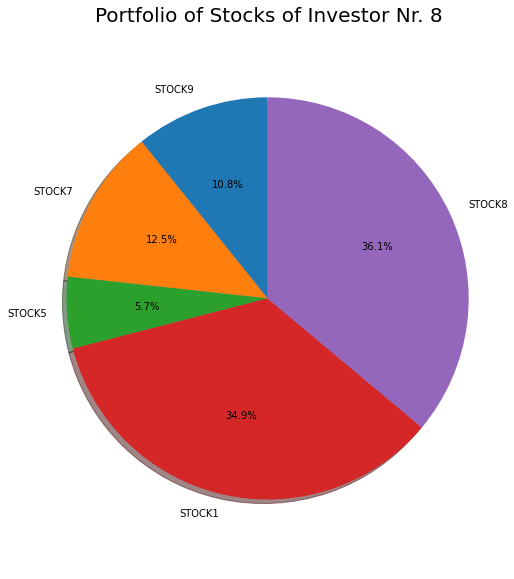

In [8]:
# Pie chart of a random investor portfolio
fig, ax = plt.subplots(1, figsize=(8,10))
investor_number = 8
nonzero_portfolio = []
for stock in Investors[investor_number - 1].portfolio:
    if (stock['Shares'] != 0): nonzero_portfolio.append(stock)
        
labels = [stock['Ticker'] for stock in nonzero_portfolio]
sizes = [stock['Shares'] for stock in nonzero_portfolio]

ax.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, normalize=True)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title(F'Portfolio of Stocks of Investor Nr. {investor_number}', size=20)

plt.show()

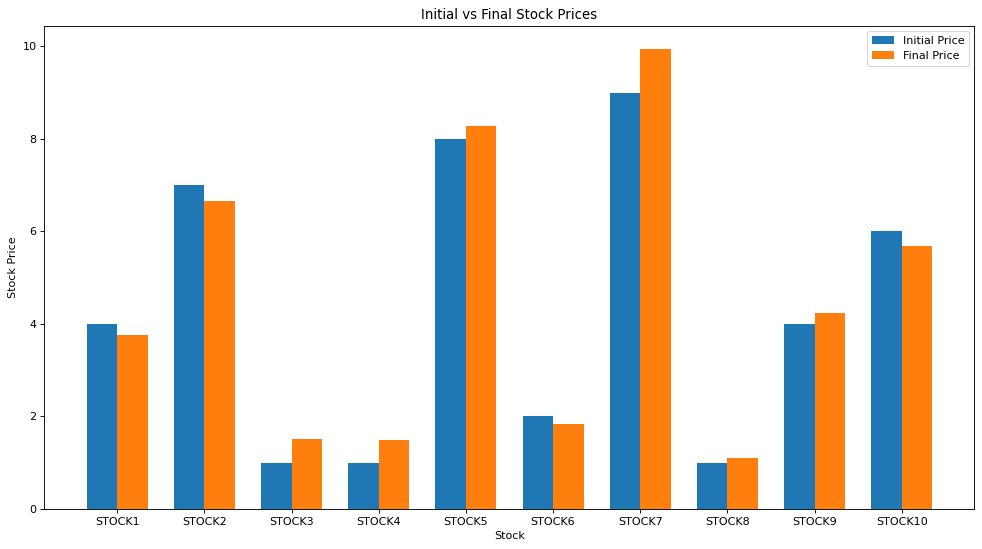

In [9]:
# Visualize the changes in stock prices
labels = [stock.ticker for stock in Market.stocks]
x = np.arange(len(labels))  # the label locations

y1 = initial_stock_prices
y2 = [stock.price for stock in Market.stocks]

width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
rects1 = ax.bar(x - width/2, y1, width, label='Earned')
rects2 = ax.bar(x + width/2, y2, width, label='Expected')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel(F'Stock')
ax.set_ylabel(F'Stock Price')
ax.set_title(F'Initial vs Final Stock Prices')
ax.set_xticks(x)
ax.set_xticklabels(labels)
legends = [F'Initial Price', 
           F'Final Price']
ax.legend(legends, loc='upper right')

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

#fig.tight_layout()

plt.show()

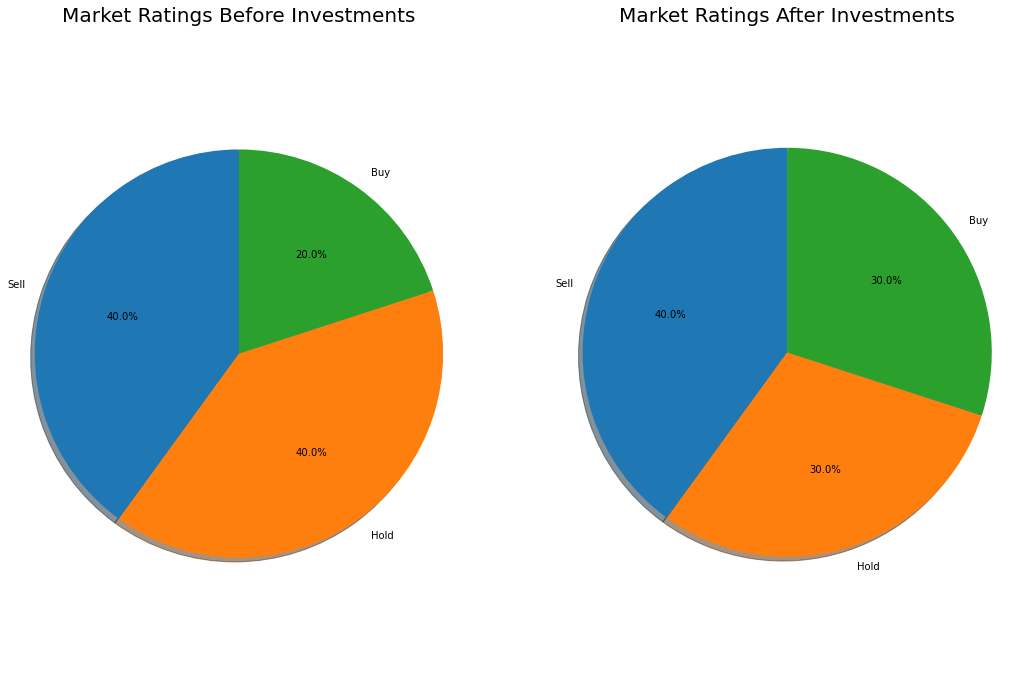

In [10]:
# Pie charts of market ratings
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18,12))

# Pie chart before investment period
labels = ["Sell", "Hold", "Buy"]
sizes1 = np.histogram(initial_market_ratings, bins=len(Ratings))[0]

ax1.pie(sizes1, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, normalize=True)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title(F'Market Ratings Before Investments', size=20)

# Pie chart after investement period
market_ratings = [stock.rating for stock in Market.stocks]
sizes2 = np.histogram(market_ratings, bins=len(Ratings))[0]

ax2.pie(sizes2, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, normalize=True)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax2.set_title(F'Market Ratings After Investments', size=20)

plt.show()

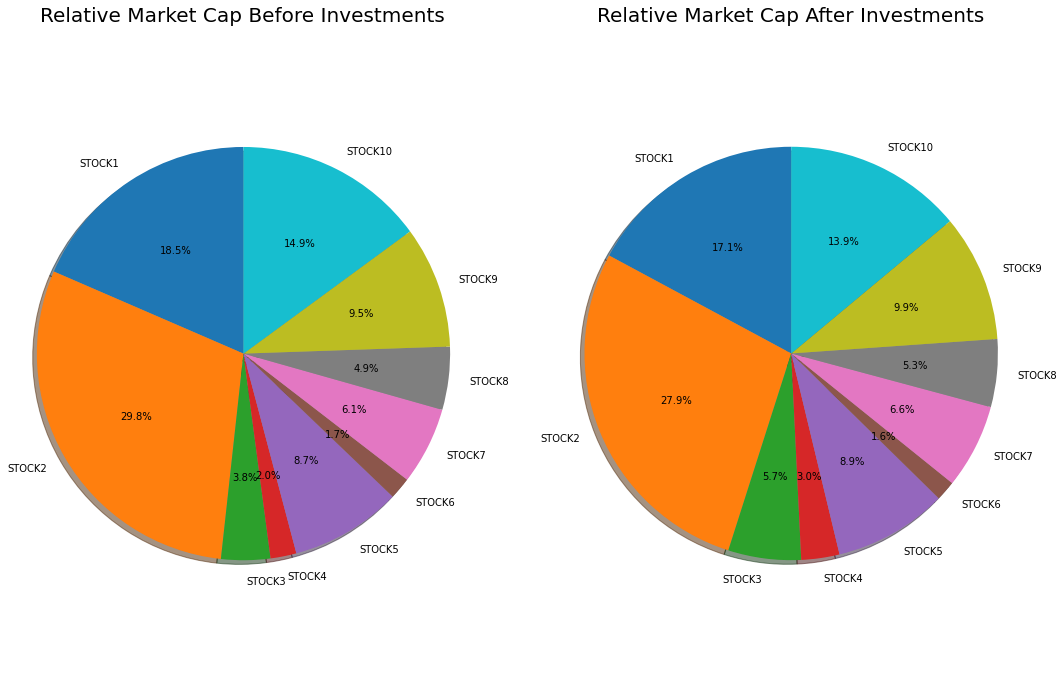

In [11]:
# Pie charts of relative market capitalizations
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18,12))

# Pie chart before investments
labels = [stock.ticker for stock in Market.stocks]
sizes1 = initial_market_share

ax1.pie(sizes1, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, normalize=True)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title(F'Relative Market Cap Before Investments', size=20)

# Pie chart after investements
sizes2 = [stock.market_cap for stock in Market.stocks]

ax2.pie(sizes2, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, normalize=True)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax2.set_title(F'Relative Market Cap After Investments', size=20)

plt.show()

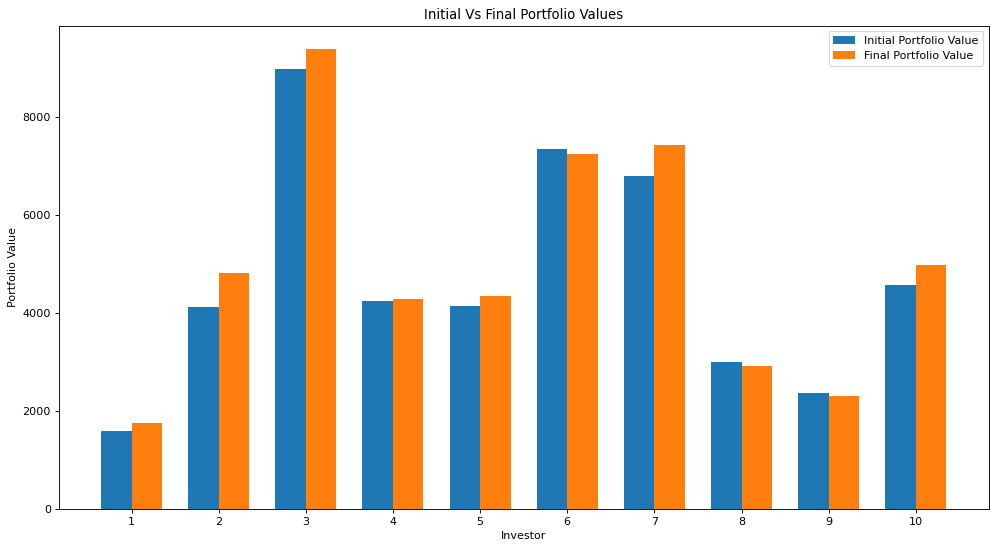

In [12]:
# Visualize the changes in portfolio values
labels = [str(p) for p in range(1, len(Investors)+1)]
x = np.arange(len(labels))  # the label locations

y1 = initial_budgets
y2 = [investor.value for investor in Investors]

width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
rects1 = ax.bar(x - width/2, y1, width, label='Earned')
rects2 = ax.bar(x + width/2, y2, width, label='Expected')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel(F'Investor')
ax.set_ylabel(F'Portfolio Value')
ax.set_title(F'Initial Vs Final Portfolio Values')
ax.set_xticks(x)
ax.set_xticklabels(labels)
legends = [F'Initial Portfolio Value', 
           F'Final Portfolio Value']
ax.legend(legends, loc='upper right')

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

#fig.tight_layout()

plt.show()

In [13]:
# How long is the trading period (in days)?
n_rounds

90

In [14]:
# How many stocks are there in the market?
n_stocks

10

In [15]:
# How many investors are there in the pool?
n_investors

10

In [16]:
# What was the initial overall market value?
initial_overall_market_value = sum(sizes1)
round(initial_overall_market_value, 2)

197289

In [17]:
# How much did the overall market gain in value?
final_overall_market_value = sum(sizes2)
market_gain = final_overall_market_value - initial_overall_market_value
round(market_gain, 2)

2649.01

In [18]:
# What was the percentage change of the market value?
round(market_gain/initial_overall_market_value*100, 2)

1.34

In [19]:
# How much money did the pool of investors have initially?
initial_total_investor_budget = sum(y1)
round(initial_total_investor_budget, 2)

47095

In [20]:
# How much money did the pool of investors put into the market (the rest is uninvested money)?
investment_into_market = initial_total_investor_budget - sum([investor.budget for investor in Investors])
round(investment_into_market, 2)

23016.48

In [21]:
# How much money did the pool of investors make from the market?
final_total_investor_value = sum(y2)
investor_money_gain = final_total_investor_value - initial_total_investor_budget
round(investor_money_gain, 2)

2321.29

In [22]:
# What was the ROI as percentage for the pool of investors?
round(investor_money_gain/investment_into_market*100, 2)

10.09

In [23]:
# A couple of utility functions
def countFrequency(list):
    freq = {}
    for items in list:
        freq[items] = list.count(items)
    freq = {k: v for k, v in sorted(freq.items(), key=lambda item: item[1], reverse = True)}
    return freq

def printDict(dict):
    for key, value in dict.items(): print ("%s : %s"%(key, value))

In [24]:
# How much did the market capitalizations of the stocks change?
stock_tickers = [stock.ticker for stock in Market.stocks]
market_cap_changes = [round(t[1] - t[0], 2) for t in zip(sizes1, sizes2)]
market_cap_changes = dict([t for t in zip(stock_tickers, market_cap_changes)])
market_cap_changes = {k: v for k, v in sorted(market_cap_changes.items(), key=lambda item: item[1], reverse = True)}
printDict(market_cap_changes)

STOCK3 : 3810.62
STOCK4 : 1971.4
STOCK7 : 1263.76
STOCK9 : 1072.22
STOCK8 : 868.61
STOCK5 : 576.83
STOCK6 : -264.58
STOCK10 : -1575.83
STOCK1 : -2217.66
STOCK2 : -2856.35


In [25]:
# How many investors are holding a particular stock?
Portfolios = [investor.portfolio for investor in Investors]
Stocks_held = [item['Ticker'] for sublist in Portfolios for item in sublist if item['Shares'] != 0]
Stocks_held = countFrequency(Stocks_held)
printDict(Stocks_held)

STOCK2 : 9
STOCK9 : 8
STOCK5 : 7
STOCK7 : 7
STOCK4 : 7
STOCK8 : 6
STOCK3 : 5
STOCK1 : 4
STOCK10 : 3
STOCK6 : 1


In [26]:
# Which stocks are held by the pool of investors?
result = [(investor.identifier, [x['Ticker'] for x in investor.portfolio if x['Shares'] != 0 ]) for investor in Investors]
portfolio_stocks = dict(result)
printDict(portfolio_stocks)

INVESTOR1 : ['STOCK8', 'STOCK9', 'STOCK5', 'STOCK7', 'STOCK2', 'STOCK4']
INVESTOR2 : ['STOCK3', 'STOCK8', 'STOCK4', 'STOCK10', 'STOCK2', 'STOCK7', 'STOCK9', 'STOCK5']
INVESTOR3 : ['STOCK5', 'STOCK9', 'STOCK2', 'STOCK3', 'STOCK1', 'STOCK4']
INVESTOR4 : ['STOCK5', 'STOCK4', 'STOCK2', 'STOCK3', 'STOCK7']
INVESTOR5 : ['STOCK6', 'STOCK10', 'STOCK8', 'STOCK9', 'STOCK5', 'STOCK2', 'STOCK7', 'STOCK4']
INVESTOR6 : ['STOCK5', 'STOCK9', 'STOCK7', 'STOCK4', 'STOCK3', 'STOCK2']
INVESTOR7 : ['STOCK3', 'STOCK2', 'STOCK4', 'STOCK8']
INVESTOR8 : ['STOCK9', 'STOCK7', 'STOCK5', 'STOCK1', 'STOCK8']
INVESTOR9 : ['STOCK9', 'STOCK2', 'STOCK1', 'STOCK8', 'STOCK7']
INVESTOR10 : ['STOCK2', 'STOCK1', 'STOCK10', 'STOCK9']
